# NYC Parking Tickets: Violation Rate Prediction

In [230]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

from datetime import datetime, timedelta

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# importing libraries

import csv
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [231]:
df = pd.read_csv('all_data_for_one_street.csv')
df['Violation Datetime'] = pd.to_datetime(df['Violation Datetime'])

df['Violation Datetime (Month)'] = df['Violation Datetime'].dt.month
df['Violation Datetime (Day)'] = df['Violation Datetime'].dt.day
df['Violation Datetime (Year)'] = df['Violation Datetime'].dt.year
df['Violation Datetime (Hour)'] = df['Violation Datetime'].dt.hour

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Issue Date                  14803 non-null  object        
 1   Violation Precinct          14803 non-null  int64         
 2   Violation Time              14803 non-null  object        
 3   Street Name                 14803 non-null  object        
 4   Violation Datetime          14803 non-null  datetime64[ns]
 5   Violation_Rate              14803 non-null  float64       
 6   Violation Datetime (Month)  14803 non-null  int32         
 7   Violation Datetime (Day)    14803 non-null  int32         
 8   Violation Datetime (Year)   14803 non-null  int32         
 9   Violation Datetime (Hour)   14803 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(3)
memory usage: 925.3+ KB


In [233]:
df_1 = df.copy()

In [234]:
df_street = df_1[['Violation Datetime', 'Violation_Rate']]
df_street

,Violation Datetime,Violation_Rate
0,2016-06-29 16:23:00,20.000000
1,2016-06-29 20:40:00,16.666667
2,2016-06-30 08:52:00,50.000000
3,2016-06-30 08:53:00,50.000000
4,2016-06-30 08:55:00,50.000000
...,...,...
14798,2023-09-28 03:09:00,9.803922
14799,2023-09-28 03:11:00,9.803922
14800,2023-09-28 03:13:00,9.803922
14801,2023-09-28 03:15:00,9.803922


In [235]:
def plot_outlier_detection(j, idx, rmeans, upper, lower):
    plt.figure(figsize=(14, 4))
    plt.plot(j)
    plt.plot(upper, color = 'blue')
    plt.plot(lower, color = 'blue')
    plt.plot(rmeans, color = 'red')
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.scatter(j.index[idx], j[idx], color = 'yellow', zorder=10)
    plt.show()

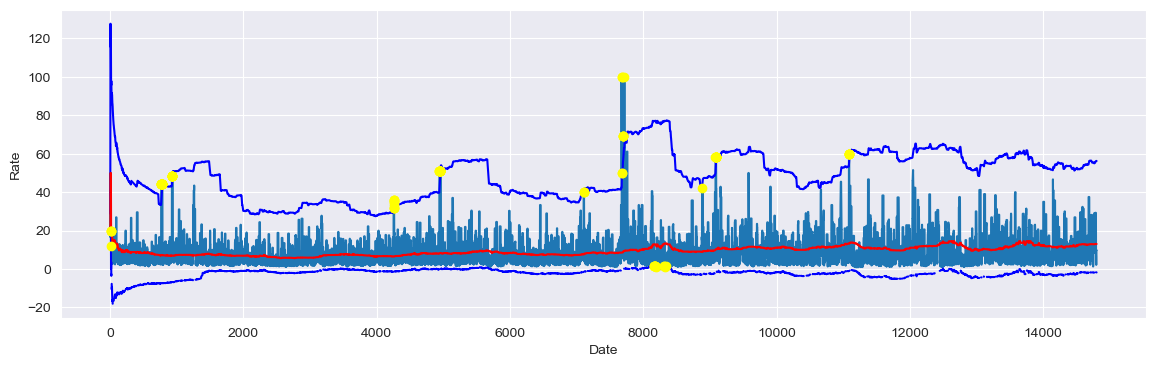

In [236]:
def outlier_detection_kurtosis(j, std_param=3, window_length=720):
    rmeans = j.rolling(window_length, min_periods=1).median()
    rstd = j.rolling(window_length, min_periods=1).std()
    rstd_lower = j[j.values < rmeans.values].rolling(window_length, min_periods=1).std()

    kurtosis_value = j.kurt()

    upper = rmeans + std_param * rstd * np.exp(0.08 * kurtosis_value)
    lower = rmeans - (4.95 * rstd_lower)
    idx1 = (j.values > upper.values)
    idx2 = (j.values < lower.values)

    idx = idx1 | idx2

    return j, idx, rmeans, upper, lower

j, idx, rmeans, upper, lower = outlier_detection_kurtosis(df_street['Violation_Rate'])
plot_outlier_detection(j, idx, rmeans, upper, lower)
j[idx] = np.nan

In [237]:
df_street['Violation_Rate'].isnull().sum()

101

In [238]:
df_street = df_street.interpolate(method='linear', limit_direction='both')

In [239]:
df_street['Violation_Rate'].isnull().sum()

0

In [240]:
df_street = df_street.set_index('Violation Datetime')

In [241]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,50.000000
2016-06-30 08:55:00,50.000000
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,9.803922
2023-09-28 03:13:00,9.803922


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


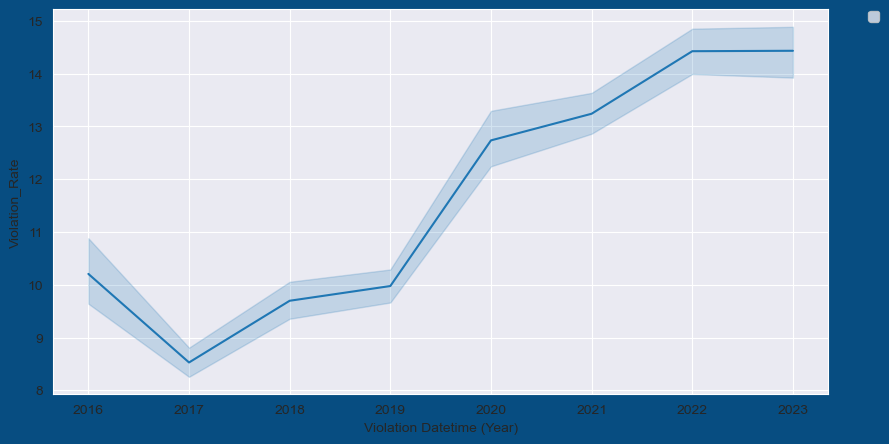

In [242]:
plt.figure(figsize=(10,5),facecolor="#074d81")
ax=sns.lineplot(x="Violation Datetime (Year)", y="Violation_Rate", data=df_1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

Text(0.5, 0, 'Date')

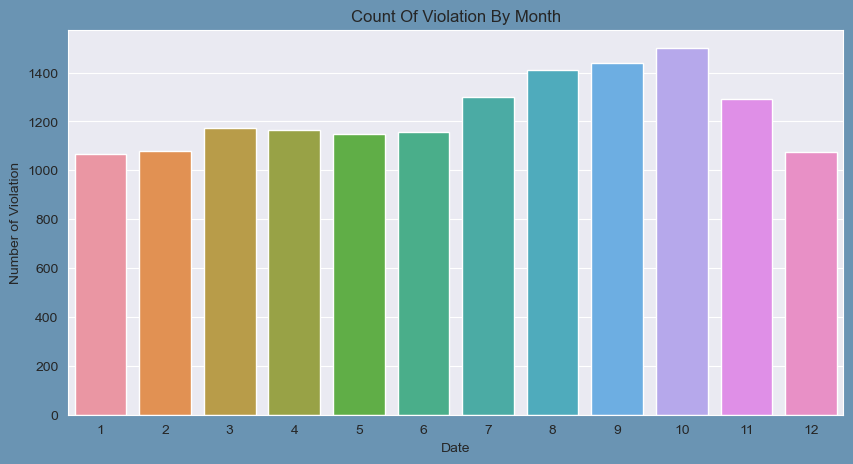

In [243]:
plt.figure(figsize=(10,5),facecolor="#6a94b3")
count = sns.countplot(data=df, x=df_1["Violation Datetime (Month)"])
count.set_title("Count Of Violation By Month")
count.set_ylabel("Number of Violation")
count.set_xlabel("Date")

In [244]:
df_street.describe()

,Violation_Rate
count,14803.000000
mean,11.509460
std,8.931427
min,0.884956
25%,4.761905
50%,9.090909
75%,15.909091
max,61.111111


In [245]:
df_street.head()

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,50.000000
2016-06-30 08:55:00,50.000000


In [246]:
def plots(df_, start_date=None, end_date=None, title=None):

    if start_date is not None and end_date is not None:
        df_ = df_street[(df_street.index >= start_date) & (df_street.index <= end_date)]

    plt.figure(figsize=(15, 8))
    # plt.plot(df_.index, df_['Violation Rate (Scaled)'], label='Violation Rate')
    plot = sns.lineplot(data=df_)
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.title(title)

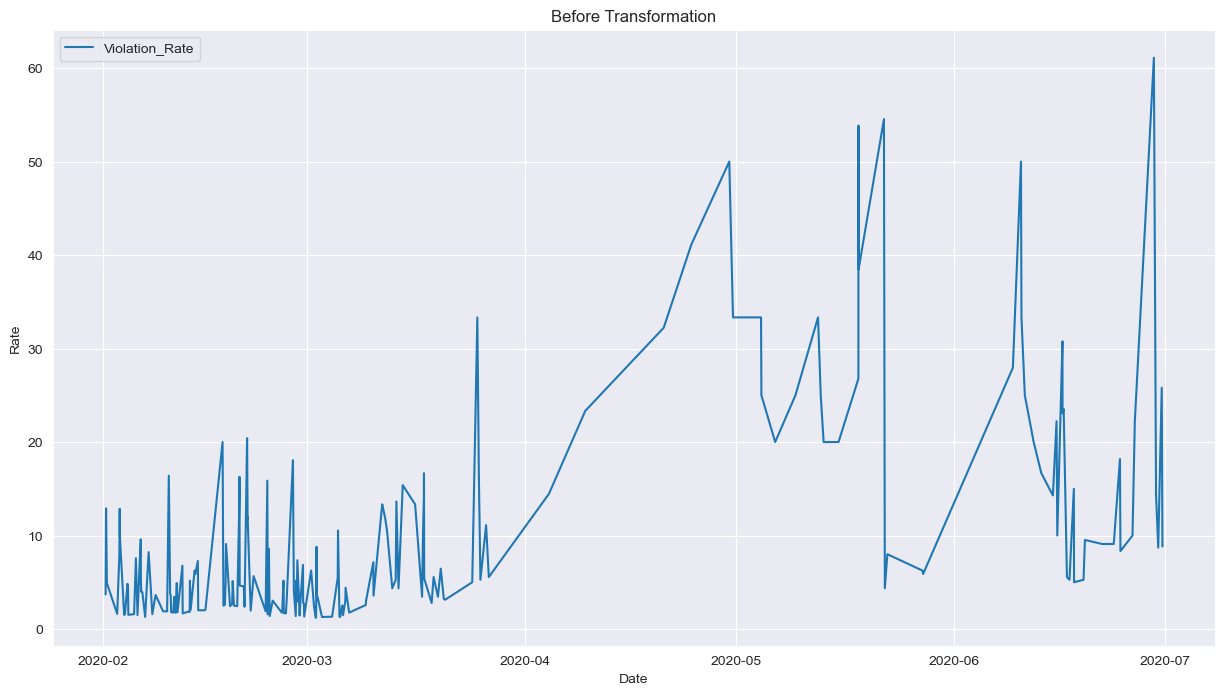

In [247]:
plots(df_street, start_date='2020-02-01 00:00:00', end_date='2020-07-01 00:00:00', title='Before Transformation')

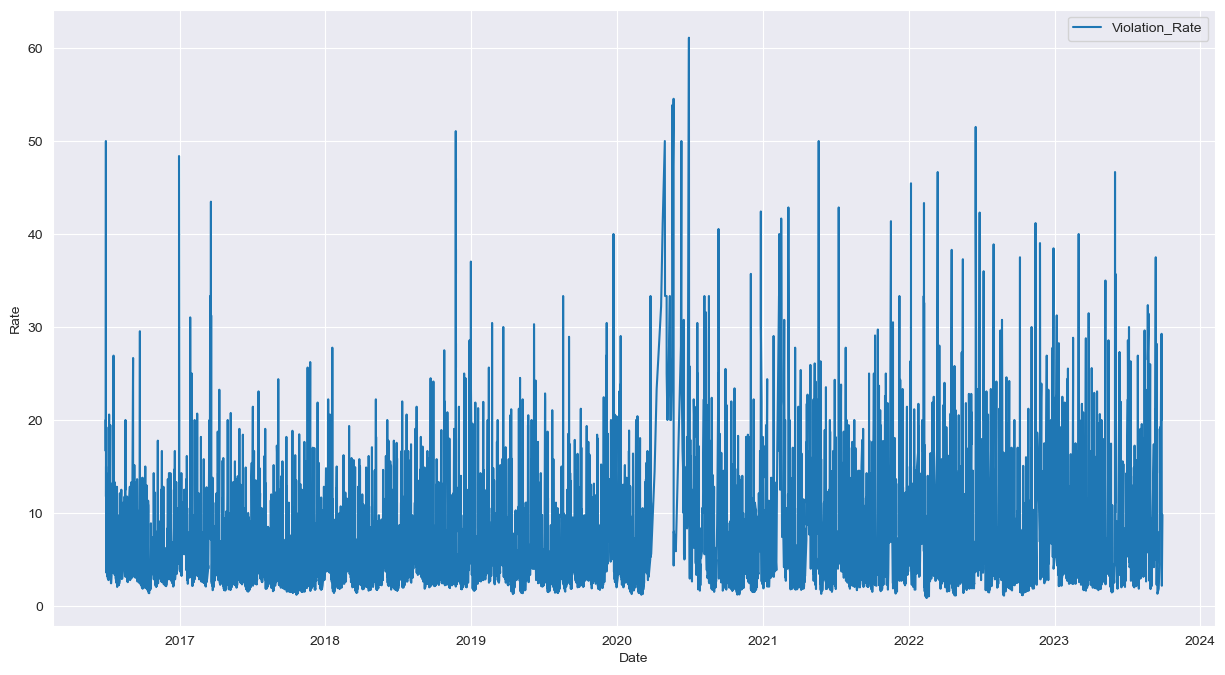

In [248]:
plots(df_street)

In [249]:
df_street['Violation_Rate']

Violation Datetime
2016-06-29 16:23:00    20.000000
2016-06-29 20:40:00    16.666667
2016-06-30 08:52:00    50.000000
2016-06-30 08:53:00    50.000000
2016-06-30 08:55:00    50.000000
                         ...    
2023-09-28 03:09:00     9.803922
2023-09-28 03:11:00     9.803922
2023-09-28 03:13:00     9.803922
2023-09-28 03:15:00     9.803922
2023-09-28 03:17:00     9.803922
Name: Violation_Rate, Length: 14803, dtype: float64

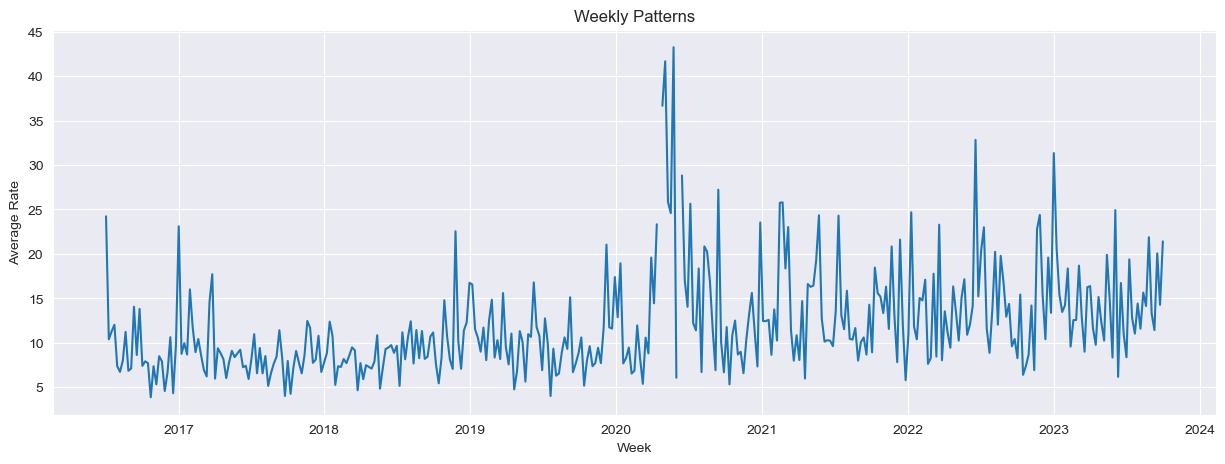

In [250]:
weekly_data = df_street.resample('W').mean()  # Weekly average
plt.figure(figsize=(15, 5))
plt.plot(weekly_data['Violation_Rate'])
plt.title('Weekly Patterns')
plt.xlabel('Week')
plt.ylabel('Average Rate')
plt.show()

In [251]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 16:23:00,20.000000
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,50.000000
2016-06-30 08:55:00,50.000000
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,9.803922
2023-09-28 03:13:00,9.803922


Steps for Transforming: Normalizing - Differencing

In [252]:
# Normalize Function
def normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [253]:
df_normalized_street, av_J1, std_J1 = normalize(df_street, "Violation_Rate")
diff_street = difference(df_normalized_street, col="Violation_Rate", interval=1) #taking a day's difference
df_normalized_street = df_normalized_street[1:]
df_street = df_street[1:]
df_normalized_street.columns = ["Norm"]
df_normalized_street["Diff"]= diff_street
df_normalized_street.head()

,Norm,Diff
Violation Datetime,,
2016-06-29 20:40:00,0.577422,-0.373214
2016-06-30 08:52:00,4.309562,3.732140
2016-06-30 08:53:00,4.309562,0.000000
2016-06-30 08:55:00,4.309562,0.000000
2016-06-30 08:56:00,4.309562,0.000000


In [254]:
df_normalized_street

,Norm,Diff
Violation Datetime,,
2016-06-29 20:40:00,0.577422,-0.373214
2016-06-30 08:52:00,4.309562,3.732140
2016-06-30 08:53:00,4.309562,0.000000
2016-06-30 08:55:00,4.309562,0.000000
2016-06-30 08:56:00,4.309562,0.000000
...,...,...
2023-09-28 03:09:00,-0.190959,0.854288
2023-09-28 03:11:00,-0.190959,0.000000
2023-09-28 03:13:00,-0.190959,0.000000


In [255]:
df_normalized_street, df_street

(                         Norm      Diff
 Violation Datetime                     
 2016-06-29 20:40:00  0.577422 -0.373214
 2016-06-30 08:52:00  4.309562  3.732140
 2016-06-30 08:53:00  4.309562  0.000000
 2016-06-30 08:55:00  4.309562  0.000000
 2016-06-30 08:56:00  4.309562  0.000000
 ...                       ...       ...
 2023-09-28 03:09:00 -0.190959  0.854288
 2023-09-28 03:11:00 -0.190959  0.000000
 2023-09-28 03:13:00 -0.190959  0.000000
 2023-09-28 03:15:00 -0.190959  0.000000
 2023-09-28 03:17:00 -0.190959  0.000000
 
 [14802 rows x 2 columns],
                      Violation_Rate
 Violation Datetime                 
 2016-06-29 20:40:00       16.666667
 2016-06-30 08:52:00       50.000000
 2016-06-30 08:53:00       50.000000
 2016-06-30 08:55:00       50.000000
 2016-06-30 08:56:00       50.000000
 ...                             ...
 2023-09-28 03:09:00        9.803922
 2023-09-28 03:11:00        9.803922
 2023-09-28 03:13:00        9.803922
 2023-09-28 03:15:00        9.8

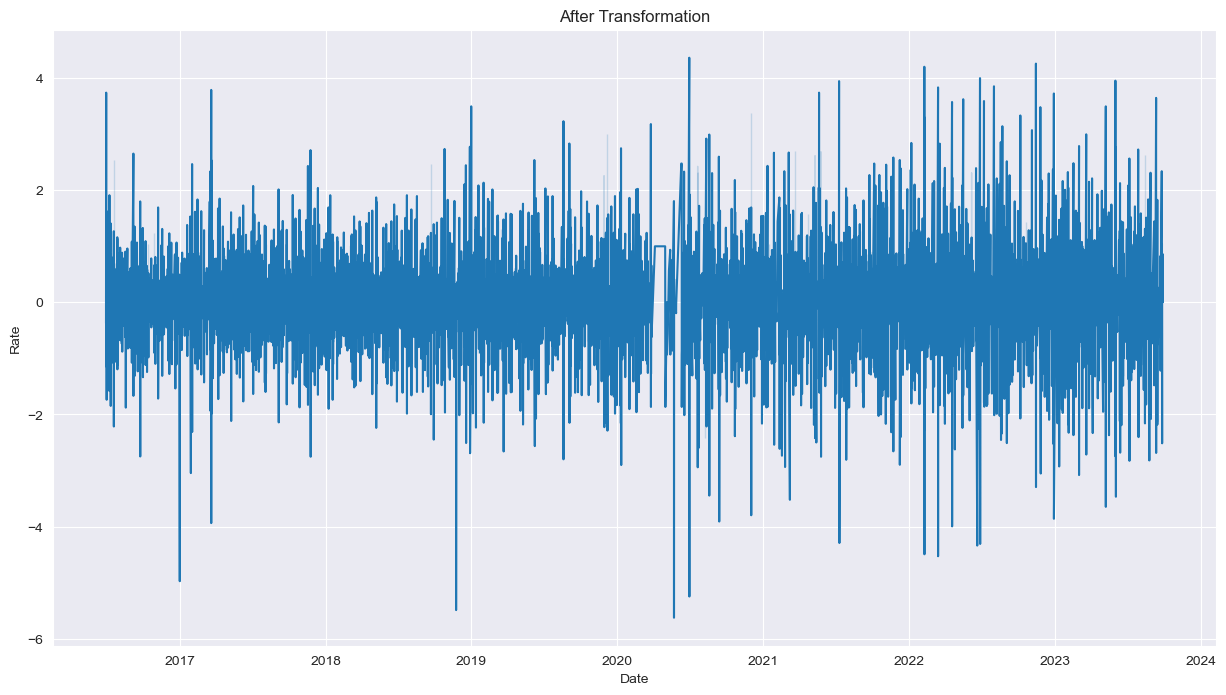

In [256]:
plots(df_normalized_street.Diff, title='After Transformation')

In [257]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df_all_junctions):
    check = adfuller(df_all_junctions.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")

#Checking if the series is stationary
check_stationary(df_normalized_street.Diff)

ADF Statistic: -29.646668494595318
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [258]:
df_street

,Violation_Rate
Violation Datetime,
2016-06-29 20:40:00,16.666667
2016-06-30 08:52:00,50.000000
2016-06-30 08:53:00,50.000000
2016-06-30 08:55:00,50.000000
2016-06-30 08:56:00,50.000000
...,...
2023-09-28 03:09:00,9.803922
2023-09-28 03:11:00,9.803922
2023-09-28 03:13:00,9.803922


In [259]:
df_street_not_normalized = df_street.copy()
df_street = df_normalized_street["Diff"].dropna()  #dropping null values
df_street = df_street.to_frame()

In [260]:
df_street

,Diff
Violation Datetime,
2016-06-29 20:40:00,-0.373214
2016-06-30 08:52:00,3.732140
2016-06-30 08:53:00,0.000000
2016-06-30 08:55:00,0.000000
2016-06-30 08:56:00,0.000000
...,...
2023-09-28 03:09:00,0.854288
2023-09-28 03:11:00,0.000000
2023-09-28 03:13:00,0.000000


In [261]:
#Splitting the dataset
def split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

#Splitting the training and test datasets
df_street_train, df_street_test = split_data(df_street)

In [262]:
#Target and Feature - We are using the previous 'steps' time periods to predict the next time period.
def target_and_feature(df):
    end_len = len(df)
    X = []
    y = []
    steps = 24
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

In [263]:
#fixing the shape of X_test and X_train
def feature_fix_shape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [264]:
df_street_train

array([[-0.37321398],
       [ 3.73213977],
       [ 0.        ],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [265]:
# Assigning features and target
X_train_street, y_train_street = target_and_feature(df_street_train)
X_test_street, y_test_street = target_and_feature(df_street_test)
X_train_street, X_test_street = feature_fix_shape(X_train_street, X_test_street)

In [266]:
X_train_street.shape

(11817, 24, 1)

In [267]:
y_train_street.shape

(11817,)

In [268]:
def lstm_model(X_train, y_train, X_test, y_test): # Model for the prediction
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) # early stopping to prevent overfitting

    # The LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Learning rate and momentum settings
    model.compile(optimizer="adamax", loss='mean_squared_error')
    model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping], shuffle=False)
    pred_lmts = model.predict(X_test)
    return pred_lmts


def rmse_value(test, predicted): # To calculate the root mean squared error in predictions
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

# def r2_score(test, predicted): # To calculate the r2 score in predictions
#     r2 = r2_score(test, predicted)
#     print("The r2 score is {}.".format(r2))
#     return r2


def predictions_plot(test, predicted, m): # To plot the comparative plot of targets and predictions
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    plt.plot(test, label="True Value", alpha=0.5)
    plt.plot(predicted, color="#627D78", label="Predicted Values")
    plt.title("LSTM Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()

In [269]:
pred_street = lstm_model(X_train_street,y_train_street,X_test_street, y_test_street) # #Predictions

Epoch 1/50
99/99 [==============================] - 21s 136ms/step - loss: 0.2578 - val_loss: 0.3596
Epoch 2/50
99/99 [==============================] - 11s 108ms/step - loss: 0.2553 - val_loss: 0.3582
Epoch 3/50
99/99 [==============================] - 11s 115ms/step - loss: 0.2539 - val_loss: 0.3576
Epoch 4/50
99/99 [==============================] - 12s 118ms/step - loss: 0.2527 - val_loss: 0.3555
Epoch 5/50
99/99 [==============================] - 11s 110ms/step - loss: 0.2511 - val_loss: 0.3533
Epoch 6/50
99/99 [==============================] - 12s 123ms/step - loss: 0.2498 - val_loss: 0.3514
Epoch 7/50
99/99 [==============================] - 11s 116ms/step - loss: 0.2481 - val_loss: 0.3497
Epoch 8/50
99/99 [==============================] - 11s 110ms/step - loss: 0.2469 - val_loss: 0.3481
Epoch 9/50
99/99 [==============================] - 11s 116ms/step - loss: 0.2458 - val_loss: 0.3462
Epoch 10/50
99/99 [==============================] - 11s 113ms/step - loss: 0.2437 - val_lo

In [270]:
y_test_street.shape

(2937,)

In [271]:
pred_street.shape

(2937, 1)

The root mean squared error is 0.5658280993828971.


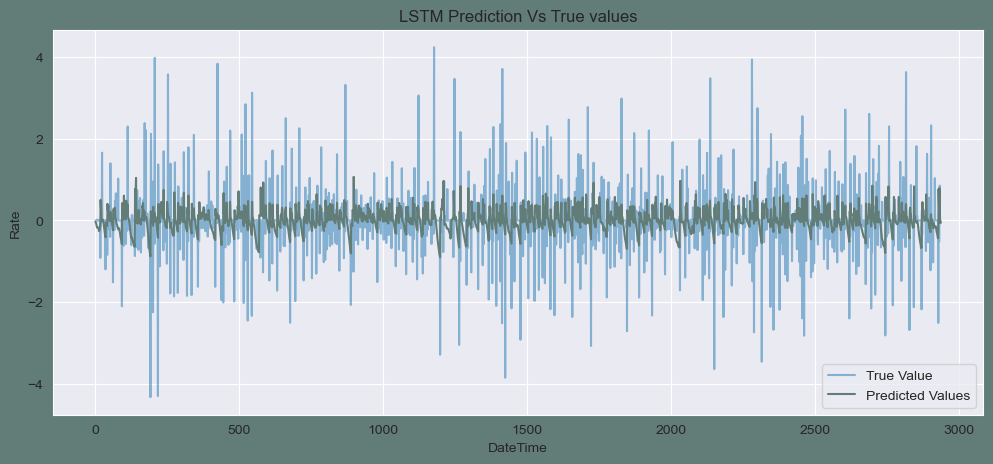

In [272]:
rmse = rmse_value(y_test_street, pred_street) # Results
predictions_plot(y_test_street, pred_street, 0)

In [273]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1)
    axes[0].set(ylabel ="Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2["Violation_Rate"], color="#627D78")
    axes[1].set(ylabel ="Original")

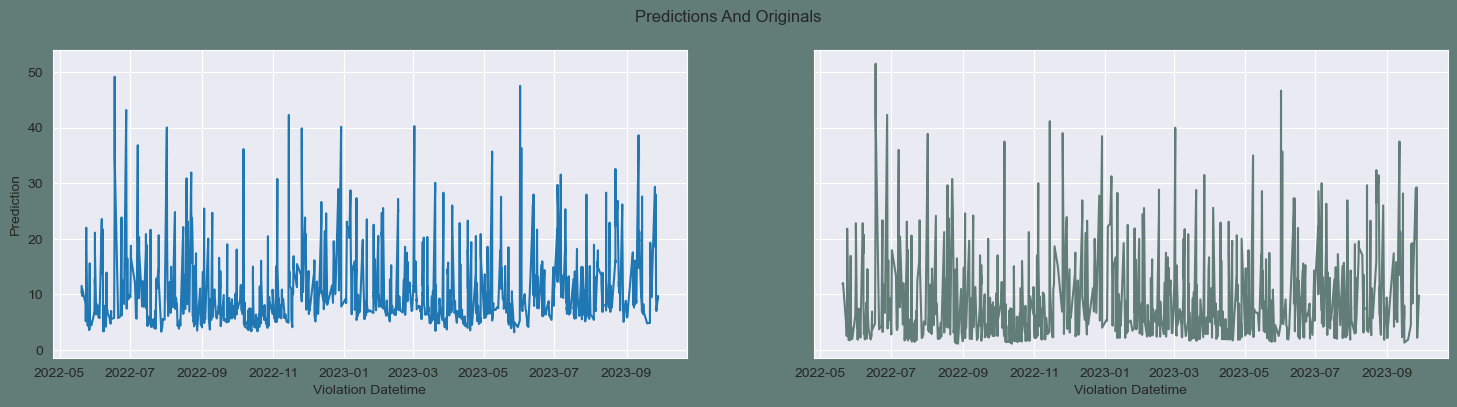

In [278]:
# invert the differenced forecas
recover_1 = df_normalized_street.Norm[-2938:-1].to_frame()
recover_1["Pred"]= pred_street
transform_reversed = inverse_difference(recover_1.Norm, recover_1.Pred).to_frame()
transform_reversed.columns = ["Pred_Normed"]
#Invert the normalization
final_pred = (transform_reversed.values* std_J1) + av_J1
transform_reversed["Pred_Final"] = final_pred
#Plotting the Predictions with originals
sub_plots_2(transform_reversed["Pred_Final"], df_street_not_normalized[-2938:-1],"Predictions And Originals", 0)

In [279]:
combined_df = pd.concat([transform_reversed["Pred_Final"], df_street_not_normalized[-2938:-1]], axis=1)
combined_df.columns = ["Pred", "Original"]
combined_df

,Pred,Original
Violation Datetime,,
2022-05-20 00:08:00,11.517852,11.842105
2022-05-20 00:09:00,11.475718,11.842105
2022-05-20 00:09:00,11.312947,11.842105
2022-05-20 00:10:00,11.043478,11.842105
2022-05-20 00:12:00,10.770494,11.842105
...,...,...
2023-09-26 15:28:00,6.998724,2.173913
2023-09-28 03:09:00,9.700180,9.803922
2023-09-28 03:11:00,9.218165,9.803922
